# Load Signals from CSV

You would need Signavio credentials - check if you can access:

https://editor.signavio.com/g/statics/pi/areas

Create *.env* file
```js
MY_SIGNAVIO_PASSWORD=*****
MY_SIGNAVIO_NAME=alexey.streltsov@sap.com

This notebook provides a collection of cells where we load signals from CSV files.
CSV files have been created by extracting Signals from several workspaces by means of Signavio API backend calls.

Here we can run API call to validate Signals against Signavio workspace view. - this step can take 25 mins.

```bash
ls -ltr schemas_from_views_2023-11-28T07_35_58.csv signals_2023-11-28T07_35_58.csv LoadSignalsFromCSV.ipynb
-rw-r--r--@ 1 d071932  staff   573K Nov 28 07:35 schemas_from_views_2023-11-28T07_35_58.csv
-rw-r--r--@ 1 d071932  staff    10M Nov 28 07:35 signals_2023-11-28T07_35_58.csv
-rw-r--r--  1 d071932  staff   1.1M Nov 29 12:31 LoadSignalsFromCSV.ipynb

```


In [1]:
! ls -ltrah schemas_from_views_*.csv signals_*.csv LoadSignalsFromCSV.ipynb

-rw-r--r--  1 d071932  staff   577K Feb  1 10:44 schemas_from_views_2024-02-01T10_44_03.csv
-rw-r--r--  1 d071932  staff    11M Feb  1 10:44 signals_2024-02-01T10_44_03.csv
-rw-r--r--  1 d071932  staff   1.1M Feb  1 10:49 LoadSignalsFromCSV.ipynb


In [2]:
# Define your access to Signavio UI here or in bash env
#%env MY_SIGNAVIO_PASSWORD=*****
#%env MY_SIGNAVIO_NAME=alexey.streltsov@sap.com

# Or via .env file
#! pip install python-dotenv
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import sys
import os
sys.path.append("./")
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

! echo $MY_SIGNAVIO_NAME

alexey.streltsov@sap.com


In [3]:
import sys
import json
import pathlib
import logging
import requests
import os
import time

logging.getLogger("urllib3").setLevel(logging.WARNING)
sys.path.append("./")

# Class coped and modified  from https://github.com/signavio/bpmn2constraints/blob/main/tutorial/SignavioAuthenticator.py
class SignavioAuthenticatorCoE:
    def __init__(self, system_instance, tenant_id, email, pw):
        self.system_instance = system_instance
        self.tenant_id = tenant_id
        self.email = email
        self.pw = pw

    """
    Takes care of authentication against Signavio systems
    """

    def authenticate(self):
        """
        Authenticates user at Signavio system instance and initiates session.
        Returns:
            dictionary: Session information
        """
        login_url = self.system_instance + "/p/login"
        data = {"name": self.email, "password": self.pw, "tokenonly": "true"}
        #if "tenant_id" in locals():
        #    data["tenant"] = self.tenant_id
        data["tenant"] = self.tenant_id
        # authenticate
        login_request = requests.post(login_url, data)

        # retrieve token and session ID
        auth_token = login_request.content.decode("utf-8")
        jsesssion_ID = login_request.cookies["JSESSIONID"]

        # The cookie is named 'LBROUTEID' for base_url 'editor.signavio.com'
        # and 'editor.signavio.com', and 'AWSELB' for base_url
        # 'app-au.signavio.com' and 'app-us.signavio.com'
        lb_route_ID = login_request.cookies["LBROUTEID"]

        # return credentials
        return {
            "jsesssion_ID": jsesssion_ID,
            "lb_route_ID": lb_route_ID,
            "auth_token": auth_token,
        }
def credentials_actualization(system_instance, workspace_id, user_name, pw, auth={}):
    # get credentials for current session. They are valid for 24 hours 
    authenticator = SignavioAuthenticatorCoE(system_instance, workspace_id, user_name, pw)
    auth_data = authenticator.authenticate()
    cookies = {'JSESSIONID': auth_data['jsesssion_ID'], 'LBROUTEID': auth_data['lb_route_ID']}
    headers = {'Accept': 'application/json', 'x-signavio-id':  auth_data['auth_token']}
    print(auth_data['jsesssion_ID'],auth_data['lb_route_ID'])
    print(auth_data['auth_token'])
    auth[workspace_name]={"cookies":cookies,"headers":headers}
    return auth

# POST - need to re-run to inject the above generated credentials
#q=q_list_processes #

#def POST_Signavio(query={},cookies=cookies,headers=headers):
def POST_Signavio(query={},workspace_name="",auth={}):
        signal_endpoint = system_instance + '/g/api/pi-graphql/graphql'
        timeout=30
        try:
            query_request = requests.post(
                signal_endpoint,
                cookies=auth[workspace_name]["cookies"],
                headers=auth[workspace_name]["headers"],
                timeout=timeout,
                json=query)
            query_request.raise_for_status()
        except requests.HTTPError as ex:
            # possibly check response for a message
            raise ex  # let the caller handle it
        except requests.Timeout:
            print("request took too long")


        return query_request.json()
    


## REST API endpoint

def API_validation(query,workspacename,auth={}):
    """
    """
    #print(query)
    signal_endpoint = system_instance + '/g/api/pi-graphql/signal'
    cookies=auth[workspacename]["cookies"]
    headers=auth[workspacename]["headers"]
    
    
    try:
        query_request = requests.post(
        signal_endpoint,
        cookies=cookies,
        headers=headers,
        json={"query":query})
        #print("JS",query_request.json().keys())
        query_request.raise_for_status()
        if "data" in query_request.json().keys():            
            d = query_request.json()["data"]
            #print("data type", type(d), d)
            #print("data type np:", type(d), len(np.asarray(d)), np.asarray(d))
            #print("data type", type(d), len(d), json.dumps(d))
            #d=np.asarray(d)
            l = len(d) 
            d=json.dumps(d)[:100]
            message="ok" # 'errorType': 'ColumnNotFound', 'message': "ColumnNotFound: 'Risk Class'"}
        #else:
        #    message=query_request.json()['message']        
    except requests.HTTPError as ex:
         print("requests.HTTPError", ex,query_request.json()['message'] )
         d=f"Error {ex}"
         l=0
         message=query_request.json()['message'] 
    except Exception as e:
        print("API error:", e)
        raise e
    
    return [message,d,l]

# Credentials / API  initialization

In [4]:
# select workspace here fro credentials needed if API calls are planned
auth={}
 
user_name = os.environ.get('MY_SIGNAVIO_NAME','alexey.streltsov@sap.com') # username
pw = os.environ.get('MY_SIGNAVIO_PASSWORD', None) # Signavio password
print("Your are:",user_name)
system_instance = 'https://editor.signavio.com'
workspace_id = 'b0f07deabd3140aea5344baa686e0d84' # workspace Process AI 
workspace_name="Process AI"
credentials_actualization(system_instance, workspace_id, user_name, pw, auth=auth) 
workspace_id = 'ccf98b692d1d4e0aa895df3aab8cd905' # workspace Solutions Demo Workspace access by alexandra.dang@sap.com
workspace_name="Solutions Demo Workspace"
credentials_actualization(system_instance, workspace_id, user_name, pw, auth=auth)
auth

Your are: alexey.streltsov@sap.com
7FC15A8DB7062F2085921FE05F66AC29 "b0bef9bd73f538ca"
df1f9cdbdd01483ea868618bf34ab628
D25B1A81404DBCFDC7834F642726AD24 "038ac76d96abd5c3"
e39aa6ccb9b849cca08b1c57200190d6


{'Process AI': {'cookies': {'JSESSIONID': '7FC15A8DB7062F2085921FE05F66AC29',
   'LBROUTEID': '"b0bef9bd73f538ca"'},
  'headers': {'Accept': 'application/json',
   'x-signavio-id': 'df1f9cdbdd01483ea868618bf34ab628'}},
 'Solutions Demo Workspace': {'cookies': {'JSESSIONID': 'D25B1A81404DBCFDC7834F642726AD24',
   'LBROUTEID': '"038ac76d96abd5c3"'},
  'headers': {'Accept': 'application/json',
   'x-signavio-id': 'e39aa6ccb9b849cca08b1c57200190d6'}}}

## Example how to run manually -constructed SIGNALS against workspace DB:

In [5]:
# Run manually -constructed SIGNALS need for VIEW 
def signal_template(signal,view):
    return f'SELECT {signal} FROM "{view}"'
signal_endpoint = system_instance + '/g/api/pi-graphql/signal'

workspace_name="Solutions Demo Workspace"
workspace_name="Process AI"

# https://editor.signavio.com/g/statics/pi/areas/ba-3/processes/test00-1/views/defaultview-2
# https://editor.signavio.com/g/statics/pi/areas/etl-403/processes/sl-itc-dashboard-test-1/views/defaultview-529
view="defaultview-529" # for workspace_name="Solutions Demo Workspace"
view="strview-1" 
signal='AVG( (SELECT LAST(end_time) - FIRST(end_time)))'
q = {'query': signal_template(signal=signal,view=view)}
q = {'query': 'SELECT count(1) \nFROM FLATTEN("defaultview-1")'}
query_request = requests.post(
        signal_endpoint,
        cookies=auth[workspace_name]["cookies"],
        headers=auth[workspace_name]["headers"] ,
        json={'query': signal_template(signal=signal,view=view)})
query_request.json()

{'header': [{'columnName': 'AVG((SELECT LAST(end_time) - FIRST(end_time)))',
   'columnAlias': 'AVG((SELECT LAST(end_time) - FIRST(end_time)))',
   'columnRole': 'MEASURE',
   'dataType': 'DURATION'}],
 'data': [[2061973225.072404]]}

# Load CSV Pandas and data Analysis

Here we:
- Load view variables
- Statistical analysis.

In [6]:
# Here we save the above schemas and signals DF to CSV files:
from pathlib import Path  
import pandas as pd

# Latest
#CSV files with Schemas for Signals: schemas_from_views_2024-02-01T10_44_03.csv
#CSV files with Signals: signals_2024-02-01T10_44_03.csv

filename_schemas="schemas_from_views_2024-02-01T10_44_03.csv"
vdf = pd.read_csv(filename_schemas) 
print(f"CSV files with Schemas for Signals: {filename_schemas}")

filename_signals="signals_2024-02-01T10_44_03.csv"
df = pd.read_csv(filename_signals)  
print(f"CSV files with Signals: {filename_signals}")

print("Number of unfiltered Signals:",df.shape)
print("Number of vars/views:",vdf.shape)


CSV files with Schemas for Signals: schemas_from_views_2024-02-01T10_44_03.csv
CSV files with Signals: signals_2024-02-01T10_44_03.csv
Number of unfiltered Signals: (11042, 11)
Number of vars/views: (3906, 9)


/var/folders/hb/_ptqrx710ljb_2f6664d20bh0000gn/T/ipykernel_17721/1121547076.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Schemas to Data Frames

In [7]:
#vf[["name"]].describe()
vdf[["name","view"]].describe() #.value_counts

,name,view
count,3906,3906
unique,1500,34
top,CaseId,defaultview-197
freq,34,248


In [8]:
vdf

,Unnamed: 0,name,isVisible,dataType,processVariableId,filter,__typename,view,process
0,0,CaseId,True,CASE_ID,NaN,NaN,SubjectViewColumn,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...
1,1,Activity,True,EVENT_NAME,NaN,NaN,SubjectViewColumn,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...
2,2,End time,True,END_TIME,NaN,NaN,SubjectViewColumn,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...
3,3,Accounting Document Segment Primary Key,True,CHOICE,accounting-document-segment-p-39,NaN,SubjectViewColumn,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...
4,4,Amount Eligible for Cash Discount in Document ...,True,NUMBER,amount-eligible-for-cash-disc-33,NaN,SubjectViewColumn,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...
...,...,...,...,...,...,...,...,...,...
3901,3901,Net Sales,True,NUMBER,net-sales-2,NaN,SubjectViewColumn,defaultview-3,test002
3902,3902,Overdue receivable,True,NUMBER,overdue-receivable-2,NaN,SubjectViewColumn,defaultview-3,test002
3903,3903,Receivable,True,NUMBER,receivable-2,NaN,SubjectViewColumn,defaultview-3,test002
3904,3904,Rejected,True,NUMBER,rejected-2,NaN,SubjectViewColumn,defaultview-3,test002


In [9]:
# Select columns for given view/TableName
vdf[vdf["view"] == "defaultview-3"]

,Unnamed: 0,name,isVisible,dataType,processVariableId,filter,__typename,view,process
3884,3884,CaseId,True,CASE_ID,NaN,NaN,SubjectViewColumn,defaultview-3,test002
3885,3885,Activity,True,EVENT_NAME,NaN,NaN,SubjectViewColumn,defaultview-3,test002
3886,3886,End time,True,END_TIME,NaN,NaN,SubjectViewColumn,defaultview-3,test002
3887,3887,Accounts Receivable Turnover Rate,True,NUMBER,accounts-receivable-turnover--2,NaN,SubjectViewColumn,defaultview-3,test002
3888,3888,Automation Rate,True,NUMBER,automation-rate-2,NaN,SubjectViewColumn,defaultview-3,test002
3889,3889,Average Days Delinquent,True,NUMBER,average-days-delinquent-2,NaN,SubjectViewColumn,defaultview-3,test002
3890,3890,Collection Effectiveness Index,True,NUMBER,collection-effectiveness-inde-2,NaN,SubjectViewColumn,defaultview-3,test002
3891,3891,Cost per 1k Revenue,True,NUMBER,cost-per-1k-revenue-2,NaN,SubjectViewColumn,defaultview-3,test002
3892,3892,Credit Reviews per Credit FTE,True,NUMBER,credit-reviews-per-credit-fte-2,NaN,SubjectViewColumn,defaultview-3,test002
3893,3893,Credit Score,True,NUMBER,credit-score-2,NaN,SubjectViewColumn,defaultview-3,test002


## Transfer Signals read from local files from signals_all_local and extracted from workspaces signals_all to DF

In [10]:
print("Number of Signals:",df.shape)
df.head(3)

Number of Signals: (11042, 11)


,Unnamed: 0,name,query,description,meta,metric_vars,view,signalFragment,process,origin,workspace_name
0,0,Total number of created incidents,"\nSELECT\nCOUNT(case_id)\nFROM ""defaultview-54...",Total number of created incidents,metric,{},defaultview-545,SELECT COUNT(case_id) FROM THIS_PROCESS,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace
1,1,Total number of open incidents,\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SE...,Total number of open incidents,metric,{'incident_closure_events': {'name': 'incident...,defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELEC...,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace
2,2,Total number of resolved incidents,\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SE...,Total number of resolved incidents,metric,{'incident_closure_events': {'name': 'incident...,defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELEC...,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace


In [11]:
# DBG
# Check for possible substitution error: ""THIS_PROCESS"" instead "THIS_PROCESS"
df[df['query'].str.contains('""')][['query',"signalFragment"]]

,query,signalFragment
2084,"SELECT \n\t""6 - Other - Transaction (TCODE)"" A...","SELECT \n\t""6 - Other - Transaction (TCODE)"" A..."
2890,"SELECT \n\t""6 - Other - Transaction (TCODE)"" A...","SELECT \n\t""6 - Other - Transaction (TCODE)"" A..."
8166,"SELECT \nSUM((SELECT COUNT (""Request Type"")\n\...","SELECT \nSUM((SELECT COUNT (""Request Type"")\n\..."
8174,"SELECT \nSUM((SELECT COUNT (""Request Type"")\n\...","SELECT \nSUM((SELECT COUNT (""Request Type"")\n\..."


### Plot duplicates

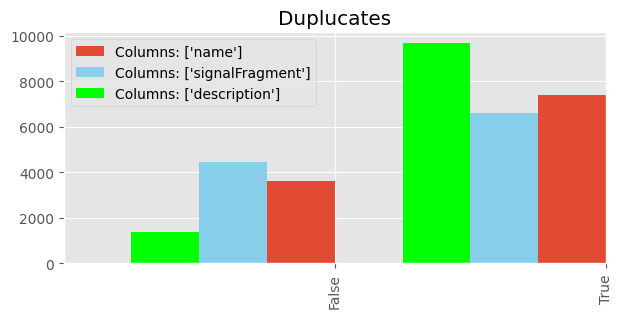

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
# Remove duplicates 
columns= df.columns.to_list() #[0:4] # problem with metrics_vars column
#columns=['name', 'query', 'description', 'meta', 'view', 'signalFragment', 'process', 'origin']
#columns.remove('metric_vars')
#columns=['name', 'query'] #, 'description']
#a= df.duplicated(columns).value_counts()
#columns=['name','signalFragment','description'] 
#columns=['signalFragment'] 
#print(columns)
#b= df.duplicated(columns).value_counts()

width = .25   
columns=['name'] 
title1=f'Columns: {columns}'
df.duplicated(columns).value_counts().sort_index().plot(kind='bar', position=1, width = width, title="Duplucates")
columns=['name','signalFragment'] 
columns=['signalFragment'] 
title2=f'Columns: {columns}'
df.duplicated(columns).value_counts().sort_index().plot(kind='bar', position=2, color='skyblue' , width = width)
columns=['name','signalFragment','description'] 
columns=['description'] 
title3=f'Columns: {columns}'
df.duplicated(columns).value_counts().sort_index().plot(kind='bar',  position=3,  color='lime',  width = width, figsize=(7,3))
plt.legend([title1,title2,title3])
plt.show()

#df.drop_duplicates(columns, keep='first',inplace=True)
#print(columns, df.shape)
#df.value_counts
#df.duplicated(columns).describe()

,name,signalFragment,query,description
count,11042,11042,11042,5101
unique,3634,4450,6444,1372


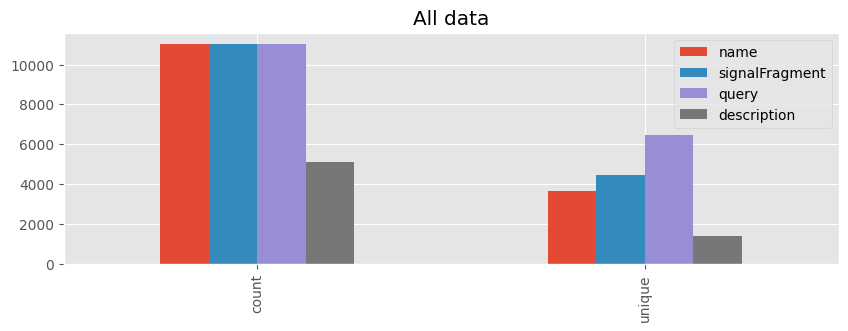

In [14]:
# number of unique records
df[['name','signalFragment','query','description']].describe().loc[['count','unique']].plot(kind='bar', title="All data",figsize=(10,3))
df[['name','signalFragment','query','description']].describe().loc[['count','unique']]

### Add columns with length of the signalFragments and WordCount to characterize complexity of the queries

In [15]:
# add  columns with length of the signalFragments
import numpy as np
import string
def words_count(text):
    t=text.replace("("," ").replace(")"," ").replace("["," ").replace("]"," ").replace("{"," ").replace("}"," ")
    return len(''.join([x for x in " ".join(t.split()) if x in string.ascii_letters + '_'+ ' ' or x.isdigit()]).split())
df['description'].replace(np.nan, "", inplace=True) # None in descriptions

df['FragmentWordCount'] = df['signalFragment'].apply(lambda x: words_count(x))
df['descriptionWordCount'] = df['description'].apply(lambda x: words_count(x))
df['nameWordCount'] = df['name'].apply(lambda x: words_count(x))

df['FragmentLength'] = df['signalFragment'].apply(lambda x: len(x))
df['descriptionLength'] = df['description'].apply(lambda x: len(x))
df['nameLength'] = df['name'].apply(lambda x: len(x)) 

df.shape
df.head(n=3)

/var/folders/hb/_ptqrx710ljb_2f6664d20bh0000gn/T/ipykernel_17721/3926161789.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].replace(np.nan, "", inplace=True) # None in descriptions


,Unnamed: 0,name,query,description,meta,metric_vars,view,signalFragment,process,origin,workspace_name,FragmentWordCount,descriptionWordCount,nameWordCount,FragmentLength,descriptionLength,nameLength
0,0,Total number of created incidents,"\nSELECT\nCOUNT(case_id)\nFROM ""defaultview-54...",Total number of created incidents,metric,{},defaultview-545,SELECT COUNT(case_id) FROM THIS_PROCESS,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace,5,5,5,39,33,33
1,1,Total number of open incidents,\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SE...,Total number of open incidents,metric,{'incident_closure_events': {'name': 'incident...,defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELEC...,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace,13,5,5,125,30,30
2,2,Total number of resolved incidents,\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SE...,Total number of resolved incidents,metric,{'incident_closure_events': {'name': 'incident...,defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELEC...,../data/metric_definitions/incident_to_resolut...,../data/metric_definitions/incident_to_resolut...,Solutions Demo Workspace,12,5,5,120,34,34


### Add columns with variables extracted from  from queries/signalFragmemts by means of custom SQL parser (sqlglot) and regexp
The extracted results are added as new columns:


In [17]:
### Extract Variables from queries/signalFragmemts by means of custom SQL parser (sqlglot) and regexp
# https://sqlglot.com/sqlglot/dialects.html
import re
from sqlglot import parse_one, exp
from sqlglot import exp
from sqlglot.dialects.dialect import Dialect
from sqlglot.generator import Generator
from sqlglot.tokens import Tokenizer, TokenType


class Signavio(Dialect):
    class Tokenizer(Tokenizer):
        QUOTES = ["'", '"']
        IDENTIFIERS = ["`"]

        KEYWORDS = {
            **Tokenizer.KEYWORDS,
            "INT64": TokenType.BIGINT,
            "FLOAT64": TokenType.DOUBLE,
            "MATCHES": TokenType.LIKE,
            "~>": TokenType.ARROW,
            "BEHAVIOUR": TokenType.COMMAND,
            "FILL": TokenType.SELECT
        }

    class Generator(Generator):
        TRANSFORMS = {exp.Array: lambda self, e: f"[{self.expressions(e)}]"}

        TYPE_MAPPING = {
            exp.DataType.Type.TINYINT: "INT64",
            exp.DataType.Type.SMALLINT: "INT64",
            exp.DataType.Type.INT: "INT64",
            exp.DataType.Type.BIGINT: "INT64",
            exp.DataType.Type.DECIMAL: "NUMERIC",
            exp.DataType.Type.FLOAT: "FLOAT64",
            exp.DataType.Type.DOUBLE: "FLOAT64",
            exp.DataType.Type.BOOLEAN: "BOOL",
            exp.DataType.Type.TEXT: "STRING",
        }
#Tokenizer.KEYWORDS['~>']
#Tokenizer.KEYWORDS['MATCHES']
#Tokenizer.KEYWORDS #['BEHAVIOUR']



def get_column_names_values(query,dialect=Signavio):
    """  
    """
    query=query.replace("\'",'"').replace('\"','"').replace("\n"," ").replace("\t"," ").replace("'",'"')
    #print(query)
    #print(">>>>>>>")
    try:
      out={ "parser_column_names": list(set([column.name for column in parse_one(query,dialect).find_all(exp.Column)])),
      "parser_values":  list(set([column.name for column in parse_one(query,dialect).find_all(exp.Literal)])),
      "parser_error": "",
      "parser":"Signavio"
      }
    except Exception as e:
        print("SQL parsing error:", e)
        v =query.replace('[',' ').replace(']',' ').replace('(',' ').replace(')',' ').replace(',',' ')
        out={ "parser_column_names":list(set([e for e in v.split(" ") if "_" in str(e)])),
            "parser_values":  list(set(re.findall("'([^']*)'", query)+re.findall('"([^"]*)"', query))),
            "parser_error": e,
            "parser":"regexp"
        }
        #raise e
    #print(out)
    return [json.dumps(out["parser_column_names"]) , json.dumps(out["parser_values"]), out["parser_error"],  out["parser"]]


#### Experiments with custom parser (can skip)

In [18]:
#### Experiments (can skip)

# Experiments start here

query="""
SELECT
AVG(
	(SELECT LAST(end_time)
		WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved'))
	-(SELECT FIRST(end_time)
		WHERE event_name IN ('Create Incident'))
)
FROM "defaultview-545"
"""

# print all column references (a and b)
for column in parse_one(query).find_all(exp.Column):
    print("column:", column) # name) #, column.alias_or_name, column.catalog )

for select in parse_one(query).find_all(exp.Select):
    print("select",select)
    for projection in select.expressions:
        print("p",projection)
        #for column in parse_one(projection).find_all(exp.Column):
        #    print("column:",column.alias_or_name, column.catalog )

# find all tables (x, y, z)
for table in parse_one(query).find_all(exp.Table):
    print("table:",table.name)

#find all values
for val in parse_one(query).find_all(exp.Literal):
    print("lit:",val ) # val.parent.args)

for val in parse_one(query).find_all(exp.Identifier):
    print("id:",val)

    
for el in parse_one(query).expressions:
    print(el)
#list(parse_one(query).find_all(exp.Var))
Signavio().Tokenizer.KEYWORDS['FILL']


indx=45
df.iloc[indx]["signalFragment"]
#print("column:", column) # name) #, column.alias_or_name, column.catalog )

s="""SELECT COUNT(1) AS "Case Count"
FROM THIS_PROCESS
WHERE "Risk Class" = 'Not evaluated'
AND
BEHAVIOUR
         (event_name = 'Create Invoice') AS create_invoice,
         ("Risk Class" = 'Not evaluated') AS no_risk_evaluation
MATCHES (no_risk_evaluation ~> create_invoice)
AND 
NOT event_name MATCHES ('Create Invoice' ~> 'Receive Payment')
AND
NOT event_name MATCHES ('Create Invoice' ~> 'Cancel Invoice')
"""
sok='SELECT COUNT(1) AS Case_Count FROM "strview-1"'

s1='SELECT AVG(\n\t(SELECT LAST(end_time)\n\t\tWHERE event_name IN (${ato_goods_receipt_events}))\n\t-(SELECT FIRST(end_time)\n\t\tWHERE event_name IN (${ato_po_creation_events}))\n   ) FROM THIS_PROCESS'

#sqlglot.transpile(sql, read='doris', pretty=True)[0]
#sqlglot.transpile(s,read='doris', pretty=True)

s2="""
SELECT (\n\t\tCOUNT(1) FILTER (WHERE event_name MATCHES ('Create Invoice'~> 'Receive Payment'))\n /\n COUNT(1)\n ) * 100 AS "Standard Invoicing Compliance Rate"\n\nFROM THIS_PROCESS
"""
s2="""
SELECT COUNT(1) AS "Case Count"
FROM THIS_PROCESS
WHERE "Risk Class" = 'Not evaluated'
AND
BEHAVIOUR
 (event_name = 'Create Invoice') AS create_invoice,
 ("Risk Class" = 'Not evaluated') AS no_risk_evaluation
MATCHES (no_risk_evaluation ~> create_invoice)
AND 
NOT event_name MATCHES ('Create Invoice' ~> 'Receive Payment')
AND
NOT event_name MATCHES ('Create Invoice' ~> 'Cancel Invoice')
"""

s2="""
 SELECT "Month"
 ,IF(count_started IS NOT NULL, count_started, 0) - IF(LAG(count_finished) OVER () IS NOT NULL, LAG(count_finished) OVER (), 0) AS "Active Cases"
 FROM (SELECT "Month"
 , SUM(count_started) OVER (ORDER BY "Month") AS count_started
 , SUM(count_finished) OVER (ORDER BY "Month") AS count_finished
 FROM (SELECT "Month"
 , COUNT(1) FILTER (WHERE started = 1) AS count_started
 , COUNT(1) FILTER (WHERE started = 0) AS count_finished
 FROM (SELECT date_trunc('month', (SELECT FIRST(end_time))) AS "Month", 
 			 1 AS started
 FROM "defaultview-9"
 UNION ALL
 SELECT date_trunc('month', (SELECT LAST(end_time))) AS "Month", 
 0 AS started
 FROM "defaultview-9") AS sub
 GROUP BY 1
 FILL TIMESERIES('month')
 ) AS sub2
 ) AS sub3
"""

#Signavio=Signavio()
#print(s2)
#sqlglot.parse(s2,dialect=Signavio)
get_column_names_values(s1,dialect=Signavio)
#print(out)

#print(s2)

#s= json.dumps({"query":s})
#json.loads(s)["query"]

#get_column_names_values(repr(s))
#import sqlglot
#sqlglot.transpile(s, read="presto", write="hive")
#dfp.apply(lambda x: API_validation(x.query,x.workspace_name, auth=auth), axis=1 ).to_list()
#dfp[["parser_column_names","parser_values","parser_error","parser"]] = dfp.apply(lambda x: get_column_names_values(x.query,Signavio), axis=1).to_list()
#repr(s)
#dfp

column: end_time
column: end_time
column: event_name
column: event_name
select SELECT AVG((SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')) - (SELECT FIRST(end_time) WHERE event_name IN ('Create Incident'))) FROM "defaultview-545"
p AVG((SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')) - (SELECT FIRST(end_time) WHERE event_name IN ('Create Incident')))
select SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')
p LAST(end_time)
select SELECT FIRST(end_time) WHERE event_name IN ('Create Incident')
p FIRST(end_time)
table: defaultview-545
lit: 'Close Incident'
lit: 'Mark Incident as Resolved'
lit: 'Create Incident'
id: "defaultview-545"
id: end_time
id: end_time
id: event_name
id: event_name
AVG((SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')) - (SELECT FIRST(end_time) WHERE event_name IN ('Create Incident')))


['["end_time", "event_name", "ato_po_creation_events", "ato_goods_receipt_events"]',
 '[]',
 '',
 'Signavio']

#### Here apply lambda with variables extraction (tales 25 secs)

In [19]:
# Here apply lambda with variables extraction (takes 25 secs)
df[["parser_column_names","parser_values","parser_error","parser"]] = df.apply(lambda x: get_column_names_values(x.query,dialect=Signavio), axis=1).to_list()

SQL parsing error: Expecting ). Line 1, Col: 105.
   SELECT AVG(  (SELECT LAST("AR_LastClearingDate")    WHERE ((NOW() - LAST(end_time)) < DURATION "60weeks"))  -(SELECT LAST("AR_LastCreationDateTime")   WHERE ((NOW() - LAST(end_time)) < DURATION "60weeks")
SQL parsing error: Expecting ). Line 1, Col: 104.
   SELECT COUNT(case_id) FILTER (  WHERE ("AR_LastNetDueDate" - "AR_LastClearingDate"    > DURATION "1day") ) / COUNT(case_id) FILTER (  WHERE ("AR_LastClearingDate" IS NOT NULL) ) * 100 FROM "defaultview-5
SQL parsing error: Expecting ). Line 1, Col: 104.
   SELECT COUNT(case_id) FILTER (  WHERE ("AR_LastClearingDate" - "AR_LastNetDueDate"    > DURATION "1day") ) / COUNT(case_id) FILTER (  WHERE ("AR_LastClearingDate" IS NOT NULL) ) * 100 FROM "defaultview-5
SQL parsing error: Expecting ). Line 1, Col: 104.
   SELECT COUNT(case_id) FILTER (  WHERE ("AR_LastClearingDate" - "AR_LastNetDueDate"    < DURATION "1day"   AND "AR_LastNetDueDate" - "AR_LastClearingDate"   < DURATION "1day"  

In [20]:
df[['name','signalFragment','query','description',"parser_column_names","parser_values","parser_error","parser"]].describe().loc[['count','unique']]

,name,signalFragment,query,description,parser_column_names,parser_values,parser_error,parser
count,11042,11042,11042,11042,11042,11042,11042,11042
unique,3634,4450,6444,1373,262,4204,1567,2


In [21]:
df[['parser']].value_counts()

parser  
Signavio    9476
regexp      1566
Name: count, dtype: int64

In [22]:
# get an element
indx=10 #4193
df.loc[[indx]]['signalFragment']
df.loc[[indx]][["workspace_name",'query','parser',"parser_column_names","parser_values"]]
#df[['query',"signalFragment","view","origin"]][indx:indx+1].values.tolist()[0]

,workspace_name,query,parser,parser_column_names,parser_values
10,Solutions Demo Workspace,"\nSELECT\nSUM(""AR_AVGClearingDays"" * ""AR_Count...",Signavio,[],"[""AR_AVGClearingDays"", ""AR_CountClearedDocumen..."


## Filter out Signals without descriptions and with None descriptions - new data frame:  DF1

Without None decriptions (11042, 21)
Signals wiht Non-empty description (11042, 21)


,name,signalFragment,query,description,view
count,11042,11042,11042,11042,11042
unique,3634,4450,6444,1373,34


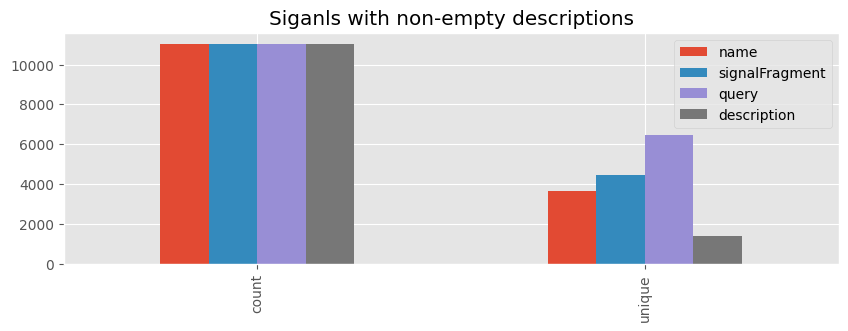

In [23]:
# Filter out Signals without descriptions and with None description
pd.set_option('display.max_colwidth', None)  
new_df = df[~df['description'].isnull()]
print("Without None decriptions", new_df.shape)

df1=new_df[new_df['description'] != "" ] # 4688 - > 1949 
df1=new_df # 4267 
print("Signals wiht Non-empty description",df1.shape)
figsize=(10,3)
df1[['name','signalFragment','query','description']].describe().loc[['count','unique']].plot(kind='bar',title="Siganls with non-empty descriptions",figsize=figsize)
df1[['name','signalFragment','query','description','view']].describe().loc[['count','unique']]


### Drop duplicates in DF1

In [24]:
# Drop duplicates
print("Number of Signals before duplicates cleaning:",df1.shape)
columns=['name','description','signalFragment']  # 1949
#columns=['name','description','query']           # 3502
#columns=['name','query']                         # 3341
#columns=['name','description']                  # 1525
#columns=['name','signalFragment']               # 1860
df1.drop_duplicates(columns, keep='first',inplace=True)
print("Number of unique Signals with not-empty descriptions after duplicate cleaning: ",df1.shape)
df1[['name','description','signalFragment','view']].describe().loc[['count','unique']]


Number of Signals before duplicates cleaning: (11042, 21)
Number of unique Signals with not-empty descriptions after duplicate cleaning:  (4881, 21)


,name,description,signalFragment,view
count,4881,4881,4881,4881
unique,3634,1373,4450,27


In [25]:
df1[['meta']].value_counts()

meta         
dashboard        1833
metric           1832
investigation    1216
Name: count, dtype: int64

## Validate pandas col with signals against log on dataFrame DF1

**26.44 mins** Number of API calls 4267   duration [mins]: 26.44 mins  0.3760855130297757 per signal call
**11mins** :API validation for 1702 took: 0.38511105219709885 per signal call


In [44]:
### q="""SELECT
### SUM(
### 	(SELECT LAST(end_time)) - (SELECT FIRST(end_time))) FILTER (
### 		WHERE (SELECT LAST(event_name) IN (None))
###    )
### FROM "defaultview-9"
### """
### 
### dfp[dfp['process']== "demo01"][["query","APIvalidated","meta"]]

### Run API Validation here new data frame DFP is used

Number of API calls 4267   duration [mins]: 26.44 mins  0.3760855130297757 per signal call



In [26]:
df_test=df1.head(n=10)
print("Number of API calls",df1.shape[0],"  duration [mins]:", 0.38*df1.shape[0]/60," View: ",df1.iloc[0]['view'])

Number of API calls 4881   duration [mins]: 30.913  View:  defaultview-545


In [27]:
# 33m 37.4s Run Signals API calls 0.3 sec per signal
start = time.time()  
#dfp=df1[df1['process']== "demo01"]
dfp=df1
dfp[['APIvalidated','validationDataResponse','validationDataLength']] = dfp.apply(lambda x: API_validation(x.query,x.workspace_name, auth=auth), axis=1 ).to_list()
delta=time.time()-start
print(f"API validation for {dfp.shape[0]} took: {delta} {(delta)/dfp.shape[0]} per signal call") # 11 mins API validation for 1702 took: 0.38511105219709885 per signal call

requests.HTTPError 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal ColumnNotFound: 'IncidentReassignmentCount'
requests.HTTPError 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal ColumnNotFound: 'IncidentReassignmentCount'
requests.HTTPError 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal ColumnNotFound: 'IncidentPriority'
requests.HTTPError 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal ColumnNotFound: 'AR_AVGClearingDays'
requests.HTTPError 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal ColumnNotFound: 'AR_AVGNetDueDateDays'
requests.HTTPError 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal ColumnNotFound: 'AR_AVGClearingAfterNetDueDays'
requests.HTTPError 422 Client Error: Un

In [28]:
dfp.shape #, dfp[['APIvalidated']] .value_counts().nlargest(100) #, dfp[['FragmentWordCount']] .value_counts().nlargest(100) 
#dfp[['APIvalidated']] .value_counts().nlargest(100)
dfp[['APIvalidated','validationDataResponse','validationDataLength',"workspace_name"]].describe()

,APIvalidated,validationDataResponse,validationDataLength,workspace_name
count,4881,4881,4881,4881
unique,925,1177,125,2
top,ok,Error 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal,0,Solutions Demo Workspace
freq,2581,2274,2347,4827


## Here we WRITE/READ data frames with validated queries to CSV 

In [30]:
#%%script echo skipping
# Here we save the above schemas and signals DF to CSV files:
from pathlib import Path
import datetime

valid_pdf = dfp[(dfp['APIvalidated'] == "ok")  & (dfp['validationDataLength'] >= 1) & (dfp['validationDataResponse'] != '[[null]]') & (dfp['validationDataResponse'] != '[[0.0]]')] 

date_str = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
filepath_validated = Path(f'subset_validated_{valid_pdf.shape[0]}_signals_{date_str}.csv')  

# WRITE
filepath_validated.parent.mkdir(parents=True, exist_ok=True)  
valid_pdf.to_csv(filepath_validated)  
print(f"WRITE CSV file with Validated Signals: {filepath_validated} shape {valid_pdf.shape}")




WRITE CSV file with Validated Signals: subset_validated_1542_signals_2024-02-01T11_33_27.csv shape (1542, 24)


In [31]:
# READ
filepath_validated_read="subset_validated_1542_signals_2024-02-01T11_33_27.csv" # shape (1542, 24)
valid_pdf = pd.read_csv(filepath_validated_read)  
print(f"READ CSV files with Validated Signals: {filepath_validated_read}")
print("Number of API-Validated queries with NON-empty data output:", valid_pdf.shape)

READ CSV files with Validated Signals: subset_validated_1542_signals_2024-02-01T11_33_27.csv
Number of API-Validated queries with NON-empty data output: (1542, 25)


# >>>>>>>>>>>>>>>>>>>>>>> From here open another notebook 

## Error Analysis

In [122]:
print("Total Number of API calls/Signals:",  df1.shape)
print("Number of API calls/Signals with errors:",  dfp[(dfp['APIvalidated'] != "ok") ].shape)
# Number of Validated queries with  reasonable data response
print("Number of API-Validated queries: ",dfp[dfp['APIvalidated'] == "ok" ]['validationDataLength'].shape)

#dfp[(dfp['APIvalidated'] == "ok")  & (dfp['validationDataLength'] == 1) & (dfp['validationDataResponse'] != '[[null]]') ] [['query','meta','validationDataResponse']]
#valid_pdf = dfp[(dfp['APIvalidated'] == "ok")  & (dfp['validationDataLength'] >= 1) & (dfp['validationDataResponse'] != '[[null]]') & (dfp['validationDataResponse'] != '[[0.0]]')] 
#valid_pdf = dfp[(dfp['APIvalidated'] == "ok")  & (dfp['validationDataLength'] >= 1) & (dfp['validationDataResponse'] != '[[null]]') ] 
print("Number of API-Validated queries with NON-empty data output:", valid_pdf.shape)

valid_pdf[['query','meta','validationDataResponse','descriptionWordCount','description','workspace_name',"parser_column_names","parser_values","parser"]]


Total Number of API calls/Signals: (4264, 24)
Number of API calls/Signals with errors: (2009, 24)
Number of API-Validated queries:  (2255,)
Number of API-Validated queries with NON-empty data output: (2042, 24)


,query,meta,validationDataResponse,descriptionWordCount,description,workspace_name,parser_column_names,parser_values,parser
0,"\nSELECT\nCOUNT(case_id)\nFROM ""defaultview-545""\n",metric,[[87812.0]],5,Total number of created incidents,Solutions Demo Workspace,"[""case_id""]",[],Signavio
1,"\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_AND(\n NOT event_name IN ('Close Incident')))\n)\nFROM ""defaultview-545""\n",metric,[[87812.0]],5,Total number of open incidents,Solutions Demo Workspace,"[""case_id"", ""event_name""]","[""Close Incident""]",Signavio
2,"\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_OR(\n event_name IN ('Close Incident')))\n)\nFROM ""defaultview-545""\n",metric,[[0.0]],5,Total number of resolved incidents,Solutions Demo Workspace,"[""case_id"", ""event_name""]","[""Close Incident""]",Signavio
5,"\nSELECT\nCOUNT(case_id) FILTER(\n\tWHERE (SELECT COUNT(DISTINCT event_name)) = (SELECT COUNT(event_name))\n\t)\nFROM ""defaultview-545""\n",metric,[[80161.0]],25,Percentage of incidents that are resolved without any rework. Rework is defined here as any case that contains the same event name more than once.,Solutions Demo Workspace,"[""case_id"", ""event_name""]",[],Signavio
6,"\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t (SELECT BOOL_OR(\n event_name IN ('Incident Response SLA Breached','Incident Resolution SLA Breached')))\n)/ COUNT(case_id)\n* 100\nFROM ""defaultview-545""\n",metric,[[0.0]],8,Percentage of cases that have breached the SLAs,Solutions Demo Workspace,"[""case_id"", ""event_name""]","[""100"", ""Incident Response SLA Breached"", ""Incident Resolution SLA Breached""]",Signavio
...,...,...,...,...,...,...,...,...,...
9752,"SELECT COUNT(1) AS ""Case Count""\nFROM ""defaultview-9""\nWHERE ""Risk Class"" = 'Not evaluated'\nAND\nBEHAVIOUR\n (event_name = 'Create Invoice') AS create_invoice,\n (""Risk Class"" = 'Not evaluated') AS no_risk_evaluation\nMATCHES (no_risk_evaluation ~> create_invoice)\nAND \nNOT event_name MATCHES ('Create Invoice' ~> 'Receive Payment')\nAND\nNOT event_name MATCHES ('Create Invoice' ~> 'Cancel Invoice')",investigation,[[102.0]],0,,Process AI,"[""no_risk_evaluation"", ""event_name"", ""create_invoice""]","[""Not evaluated"", ""Case Count"", ""Cancel Invoice"", ""defaultview-9"", ""Receive Payment"", ""Create Invoice"", ""Risk Class""]",regexp
9753,"SELECT ""Risk Class"", \n\t COUNT(1) AS ""Case Count""\nFROM ""defaultview-9""\nWHERE event_name \nMATCHES ('Create Invoice')\nAND\nNOT event_name \nMATCHES ('Create Invoice'\n\t\t~> 'Receive Payment')\nAND\nNOT event_name \nMATCHES ('Create Invoice'\n\t\t~> 'Cancel Invoice')\nGROUP BY 1\nORDER BY 2 DESC",investigation,"[[""Not evaluated"", 102.0], [""High"", 44.0], [""Medium"", 34.0], [""Low"", 16.0]]",0,,Process AI,"[""event_name""]","[""Cancel Invoice"", ""Receive Payment"", ""Create Invoice"", ""Risk Class"", ""1"", ""2""]",Signavio
9754,"SELECT ""Month""\n\t ,count_started AS ""Cases Started During Month""\n ,count_finished AS ""Cases Completed During Month""\n ,IF(count_started IS NOT NULL, count_started, 0) - IF(LAG(count_finished) OVER () IS NOT NULL, LAG(count_finished) OVER (), 0) AS ""Active Cases""\n FROM (SELECT ""Month""\n , SUM(count_started) OVER (ORDER BY ""Month"") AS count_started\n , SUM(count_finished) OVER (ORDER BY ""Month"") AS count_finished\n FROM (SELECT ""Month""\n , COUNT(1) FILTER (WHERE started = 1) AS count_started\n , COUNT(1) FILTER (WHERE started = 0) AS count_finished\n FROM (SELECT date_trunc('month', (SELECT FIRST(end_time))) AS ""Month"", \n \t\t\t 1 AS started\n FROM ""defaultview-9""\n UNION ALL\n SELECT date_trunc('month', (SELECT LAST(end_time))) AS ""Month"", \n 0 AS started\n FROM ""defaultview-9"") AS sub\n GROUP BY 1\n FILL TIMESERIES('month')\n ) AS sub2\n ) AS sub3",investigation,"[[1546300800000.0, 804.0, 395.0, 804.0], [1548979200000.0, 1110.0, 825.0, 715.0], [1551398400000.0,",0,,Process AI,"[""end_time"", ""count_started"", ""count_finished"", ""date_trunc""]","[""mon

In [107]:
valid_pdf['parser'].value_counts() , valid_pdf[['meta']].value_counts() 
#valid_pdf[['workspace_name']].value_counts() 
#valid_pdf[['process']].value_counts()

(parser
 Signavio    1671
 regexp       371
 Name: count, dtype: int64,
 meta         
 dashboard        742
 metric           676
 investigation    624
 Name: count, dtype: int64)

In [109]:
# Error analysis:
# requests.HTTPError 400 
#  df1=new_df[new_df['description'] != "" ]
#dfp["requests.HTTPError 400" in dfp['validationDataResponse'] ]
#dfp[dfp['validationDataResponse'].str.contains("requests.HTTPError 400")]
#dfp['APIvalidated'] 
#dfp[dfp['APIvalidated'] != "ok" ] [["query","APIvalidated","validationDataResponse"]] # ok

error_string="MissingDataSourceError"
error_string="MissingDataSourceError: Data source"
dbg = dfp[dfp['APIvalidated'].str.contains(error_string)] # 41 
#dbg = dfp[dfp['APIvalidated'].str.contains("ColumnNotFound")] # 1934
# dbg = dfp[dfp['APIvalidated'].str.contains("Syntax error at")]
print(dbg['APIvalidated'].describe()) #value_counts())
dbg[["query","APIvalidated","signalFragment","origin","meta"]]

#print(dbg['APIvalidated'].value_counts())

count                                                                3
unique                                                               2
top       MissingDataSourceError: Data source 'This_Process' not found
freq                                                                 2
Name: APIvalidated, dtype: object


,query,APIvalidated,signalFragment,origin,meta
499,SELECT\nAVG(\n\t(SELECT LAST(end_time)) - (SELECT FIRST(end_time))\n )\nFROM This_Process,MissingDataSourceError: Data source 'This_Process' not found,SELECT\nAVG(\n\t(SELECT LAST(end_time)) - (SELECT FIRST(end_time))\n )\nFROM This_Process,../data/pia-dashboards/ewm-outbound/Manage Warehouse and Inventory (Outbound) in SAP EWM.json,dashboard
6072,"SELECT ""PO Vendor Name"", ""PO Vendor Number"", ""PO Vendor Master Cash Discount Days 1"", ""PO Vendor Master Cash Discount Days 2"", ""PO Vendor Master Net Payment Days"", ""PO Vendor Master Terms of Payment Key""\nFROM ""This_Process""\nWHERE ""PO Vendor Name"" IS not NULL\nLIMIT 25",MissingDataSourceError: Data source 'This_Process' not found,"SELECT ""PO Vendor Name"", ""PO Vendor Number"", ""PO Vendor Master Cash Discount Days 1"", ""PO Vendor Master Cash Discount Days 2"", ""PO Vendor Master Net Payment Days"", ""PO Vendor Master Terms of Payment Key""\nFROM ""This_Process""\nWHERE ""PO Vendor Name"" IS not NULL\nLIMIT 25",../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards PTP ECC & S4H (DO NOT CHANGE/DELETE)/dashboards/zz - PO Vendor Dashboard_2023-12-04.json,dashboard
6352,"SELECT \nCOUNT (""CASE_ID"") AS ""No. of Cases"", \n""PR Plant"" AS ""PR Plant"",\n""PR Type""\nFROM ""defaultview-4""\n--WHERE (EVENT_NAME MATCHES ('Clear Invoice') AND EVENT_NAME MATCHES ('Create PR Item'))\nORDER BY 1 DESC",MissingDataSourceError: Data source 'defaultview-4' not found,"SELECT \nCOUNT (""CASE_ID"") AS ""No. of Cases"", \n""PR Plant"" AS ""PR Plant"",\n""PR Type""\nFROM ""defaultview-4""\n--WHERE (EVENT_NAME MATCHES ('Clear Invoice') AND EVENT_NAME MATCHES ('Create PR Item'))\nORDER BY 1 DESC",../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards PTP ECC & S4H (DO NOT CHANGE/DELETE)/investigations/Presales Template - HZL POV_Insights_2023-12-04.json,investigation


In [278]:
col='IncidentPriority'
vdf[vdf["name"] ==  col]

,Unnamed: 0,name,isVisible,dataType,processVariableId,filter,__typename,view,process


In [51]:
indx=5976
#df[['query',"signalFragment","view","origin","workspace_name"]][indx]
df.loc[[indx]][['query',"signalFragment","view","origin","workspace_name",'parser',"parser_column_names","parser_values"]]

,query,signalFragment,view,origin,workspace_name,parser,parser_column_names,parser_values
5976,"\nSELECT\nCOUNT(""Last FI Invoice ID"") FILTER(\n\tWHERE ""Last FI Invoice Item Cash Discount Days 1"" IS NULL\n\t\tOR ""Last FI Invoice Item Cash Discount Days 1"" = 0)\nFROM ""defaultview-124""\n","SELECT COUNT(""Last FI Invoice ID"") FILTER(\n\tWHERE ${itp_cash_discount_terms} IS NULL\n\t\tOR ${itp_cash_discount_terms} = 0) FROM THIS_PROCESS",defaultview-124,../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards PTP ECC & S4H (DO NOT CHANGE/DELETE)/metrics/metrics.json,Process AI,Signavio,[],"[""Last FI Invoice Item Cash Discount Days 1"", ""0"", ""Last FI Invoice ID""]"


In [53]:
s = df['query'].loc[[indx]].to_list()[0] #, df.loc[[indx]]['workspace_name']
f =  df['signalFragment'].loc[[indx]].to_list()[0] 
print(s)
f


SELECT
COUNT("Last FI Invoice ID") FILTER(
	WHERE "Last FI Invoice Item Cash Discount Days 1" IS NULL
		OR "Last FI Invoice Item Cash Discount Days 1" = 0)
FROM "defaultview-124"
                


'SELECT COUNT("Last FI Invoice ID") FILTER(\n\tWHERE ${itp_cash_discount_terms} IS NULL\n\t\tOR ${itp_cash_discount_terms} = 0) FROM THIS_PROCESS'

### Validate SINGLE signal against log DB

In [55]:
indx=5976
signal,signalFragment, view, origin, workspacename = df[['query',"signalFragment","view","origin","workspace_name"]][indx:indx+1].values.tolist()[0]
print(signal,signalFragment, view,workspace_name)
#API_validation(query,workspace_name, auth=auth)


SELECT
COUNT("Last FI Invoice ID") FILTER(
	WHERE "Last FI Invoice Item Cash Discount Days 1" IS NULL
		OR "Last FI Invoice Item Cash Discount Days 1" = 0)
FROM "defaultview-124"
                 SELECT COUNT("Last FI Invoice ID") FILTER(
	WHERE ${itp_cash_discount_terms} IS NULL
		OR ${itp_cash_discount_terms} = 0) FROM THIS_PROCESS defaultview-124 Process AI


In [54]:
indx=1113 # query	description	meta	metric_vars	view	signalFragment	process	
indx=5976
signal,signalFragment, view, origin, workspacename = df[['query',"signalFragment","view","origin","workspace_name"]][indx:indx+1].values.tolist()[0]
print(signal,signalFragment, view,workspace_name)
def sfromt(signal,view):
    return f'{signal}'.replace("THIS_PROCESS",f'"{view}"')
signal_endpoint = system_instance + '/g/api/pi-graphql/signal'
view1="defaultview-01"
view1=view
signalFragment=""" SELECT
   COUNT(distinct case_id) AS OnTimeManufacturing
FROM
   THIS_PROCESS
"""
q = {'query': sfromt(signal=signalFragment,view=view1)}
q = {'query': s}
print(origin, "EXEC:",q['query'])


workspacename="Solutions Demo Workspace"
#workspacename="Process AI"

cookies=auth[workspacename]["cookies"]
headers=auth[workspacename]["headers"]

query_request = requests.post(
        signal_endpoint,
        cookies=cookies,
        headers=headers,
        json=q)
print(query_request.json().keys())
print(query_request.json())
#d = query_request.json()["data"]
if "data" in query_request.json().keys():
    d = query_request.json()["data"]
    print("data type", type(d), len(d), json.dumps(d))
else:
    print(query_request.json()['message'])

#print("data type np:", type(d), len(np.asarray(d)), np.asarray(d))
#np.asarray(d)

#print(d,len(d))

../data/From_API/Solutions Demo Workspace/000_DEMO✨ - Dashboards PTP ECC & S4H (DO NOT CHANGE/DELETE)/metrics/metrics.json EXEC: 
SELECT
COUNT("Last FI Invoice ID") FILTER(
	WHERE "Last FI Invoice Item Cash Discount Days 1" IS NULL
		OR "Last FI Invoice Item Cash Discount Days 1" = 0)
FROM "defaultview-124"
                
dict_keys(['header', 'data'])
{'header': [{'columnName': 'COUNT(Last FI Invoice ID)', 'columnAlias': 'COUNT(Last FI Invoice ID)', 'columnRole': 'MEASURE', 'dataType': 'NUMBER'}], 'data': [[139.0]]}
data type <class 'list'> 1 [[139.0]]


## Investigation and plots of the  Complexity of the Signals DF1

In [281]:
dfp[["name","query","description","meta","metric_vars","view","signalFragment"]].head(n=5)

,name,query,description,meta,metric_vars,view,signalFragment
0,Total number of created incidents,"\nSELECT\nCOUNT(case_id)\nFROM ""defaultview-545""\n",Total number of created incidents,metric,{},defaultview-545,SELECT COUNT(case_id) FROM THIS_PROCESS
1,Total number of open incidents,"\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_AND(\n NOT event_name IN ('Close Incident')))\n)\nFROM ""defaultview-545""\n",Total number of open incidents,metric,"{'incident_closure_events': {'name': 'incident_closure_events', 'description': ""Events defining the closing events of a case, for example 'Close Incident'"", 'defaultValues': [{'defaultValue': ""'Close Incident'"", 'sourceSystems': ['SERVICENOW']}], 'value': ""'Close Incident'""}}",defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_AND(\n NOT event_name IN (${incident_closure_events})))\n) FROM THIS_PROCESS
2,Total number of resolved incidents,"\nSELECT\nCOUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_OR(\n event_name IN ('Close Incident')))\n)\nFROM ""defaultview-545""\n",Total number of resolved incidents,metric,"{'incident_closure_events': {'name': 'incident_closure_events', 'description': ""Events defining the closing events of a case, for example 'Close Incident'"", 'defaultValues': [{'defaultValue': ""'Close Incident'"", 'sourceSystems': ['SERVICENOW']}], 'value': ""'Close Incident'""}}",defaultview-545,SELECT COUNT(case_id) FILTER (WHERE \n\t(SELECT BOOL_OR(\n event_name IN (${incident_closure_events})))\n) FROM THIS_PROCESS
3,Average response time,"\nSELECT\nAVG(\n\t(SELECT LAST(end_time)\n\t\tWHERE event_name IN ('Assign Incident to User'))\n\t-(SELECT FIRST(end_time)\n\t\tWHERE event_name IN ('Create Incident'))\n)\nFROM ""defaultview-545""\n",Average time from incident creation to first response,metric,"{'response_events': {'name': 'response_events', 'description': ""Events defining the response to a recently opened case, for example 'Assign ticket', 'Create ticket'"", 'defaultValues': [{'defaultValue': ""'Assign Incident to User'"", 'sourceSystems': ['SERVICENOW']}], 'value': ""'Assign Incident to User'""}, 'incident_creation_events': {'name': 'incident_creation_events', 'description': ""Events defining the start events of a case, for example 'Create Problem', 'Create Incident'"", 'defaultValues': [{'defaultValue': ""'Create Incident'"", 'sourceSystems': ['SERVICENOW']}], 'value': ""'Create Incident'""}}",defaultview-545,SELECT AVG(\n\t(SELECT LAST(end_time)\n\t\tWHERE event_name IN (${response_events}))\n\t-(SELECT FIRST(end_time)\n\t\tWHERE event_name IN (${incident_creation_events}))\n) FROM THIS_PROCESS
4,Average resolution time,"\nSELECT\nAVG(\n\t(SELECT LAST(end_time)\n\t\tWHERE event_name IN ('Close Incident', 'Mark Incident as Resolved'))\n\t-(SELECT FIRST(end_time)\n\t\tWHERE event_name IN ('Create Incident'))\n)\nFROM ""defaultview-545""\n",Average time from incident creation to its resolution,metric,"{'resolution_events': {'name': 'resolution_events', 'description': ""Events defining the resolution of a case, for example 'Close Incident', 'Mark Incident as Resolved'"", 'defaultValues': [{'defaultValue': ""'Close Incident', 'Mark Incident as Resolved'"", 'sourceSystems': ['SERVICENOW']}], 'value': ""'Close Incident', 'Mark Incident as Resolved'""}, 'incident_creation_events': {'name': 'incident_creation_events', 'description': ""Events defining the start events of a case, for example 'Create Problem', 'Create Incident'"", 'defaultValues': [{'defaultValue': ""'Create Incident'"", 'sourceSystems': ['SERVICENOW']}], 'value': ""'Create Incident'""}}",defaultview-545,SELECT AVG(\n\t(SELECT LAST(end_time)\n\t\tWHERE event_name IN (${resolution_events}))\n\t-(SELECT FIRST(end_time)\n\t\tWHERE event_name IN (${incident_creation_events}))\n) FROM THIS_PROCESS


In [24]:
### Investigation and plots of the  Complexity of the Signals DF1
# plot distr
col='FragmentLength'
#col="descriptionLength"
#col="nameLength"
col="FragmentWordCount"

#col='validationDataLength'
col="descriptionWordCount"
#bins=df[col].quantile([0,.05,0.1,0.15,0.20,0.25,0.3,0.35,0.40,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]).to_list()
#bins=[50,100,150,200,250,300,350,400,450,500,550, 600, 700, 800,1000] #,2000,8000]

binwidth=1
rmax=200
rmin=0

#rmax=10000
#rmin=1000
#banwidth=10
dfplot=dfp[dfp['APIvalidated'] == "ok" ]
data_binned = dfplot[(dfplot[col]>rmin)&(dfplot[col]<rmax)]

plt.figure().set_figwidth(15)
bins=range(min(data_binned[col]), max(data_binned[col]) + binwidth, binwidth)
data_binned[col].plot(kind='hist', edgecolor='white', linewidth=1, bins=bins, alpha=0.3, histtype='barstacked', color='steelblue', title=f'Word Count distribution for {col}')
plt.xlabel("length")
plt.ylabel("Samples count")

data_binned[col].describe() #.loc[['count','min','max']]



#plt.rcParams['figure.figsize'] = [25, 5]

NameError: name 'dfp' is not defined

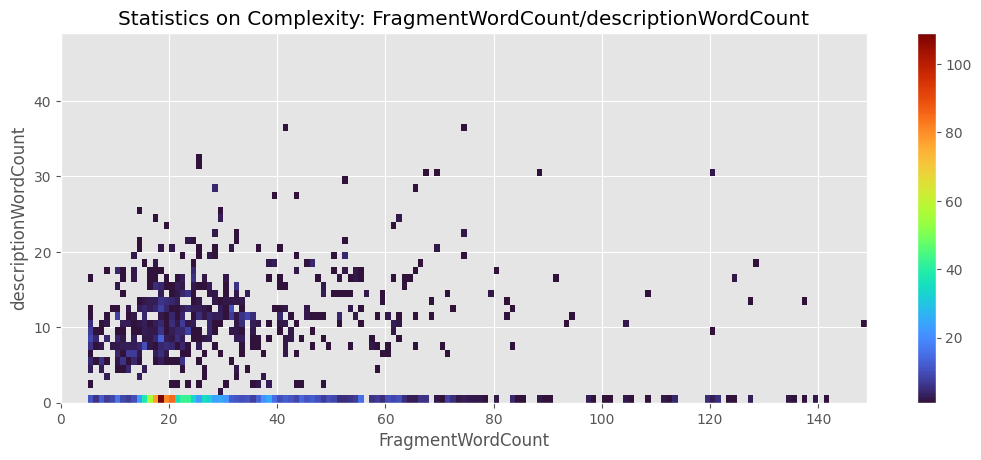

In [283]:
col1="FragmentLength"
col2='descriptionLength'
col1="FragmentWordCount"
col2="descriptionWordCount"
#col2="nameWordCount"
dfplot=dfp[dfp['APIvalidated'] == "ok" ]
datapd=dfplot[[col1,col2]]
datapd.describe()
bin_x = np.arange(0, 300, 5)
bin_y = np.arange(0, 40, 1)

bin_x = np.arange(0, 150, 1)
bin_y = np.arange(0, 50, 1)
plt.figure().set_figwidth(13)
title=f"Statistics on Complexity: {col1}/{col2}"
plt.title(title)
plt.hist2d(data=datapd, x=col1, y=col2, cmin=0.3, cmap='turbo',bins=[bin_x, bin_y])
plt.xlabel(col1)
plt.ylabel(col2)

plt.colorbar()

In [246]:
#df2=df1[df1['APIvalidated'] == "ok" ]
#df2.shape
#df1[df1['APIvalidated'] != "ok" ]
#df2

# Export for Training 


In [284]:
from hashlib import blake2b
def get_unique_file_name_hashlib(x,filename_from=['name',"description","signalFragment","query"]):
    string=str(("+").join([x[col] for col in filename_from]))
    out = blake2b(string.encode("utf-8"),digest_size=5).hexdigest()
    return out

def writejson(row, path="training_data", columns=[]):
  filename = pathlib.Path(os.path.join( path, row["filename"]+'.json'))
  pathlib.Path(filename.parent).mkdir(parents=True, exist_ok=True)
  if len(columns) >0:
    js=json.loads(row[columns].to_json())
  else:
    js=json.loads(row.to_json())
  #print (filename, row[columns].to_json())
  if "view_columns" in js.keys():
  #  print(js["view_columns"])
     js["view_columns"]=json.loads(js["view_columns"])
  try:
    with open(filename, "w") as outfile:
      json.dump(js, outfile, indent=2)
      #outfile.write(row.to_json())
      return "saved"
  except Exception as e:
    print(e)
    return "saving failed"
def get_view_columns(x):
  """_summary_
  Insert column names as stringified json to output table element
  Args:
      x (_type_): _description_

  Returns:
      _type_: _description_
  """
  out = json.dumps(vdf[vdf["view"] ==  str(x["view"]) ]["name"].to_list())
  return out

## Actual export - per each row as JSON happens here
for 4267 records takes 11 sec - fast from scratch remove previous attempts 

In [302]:
#dfp[(dfp['name'] == N)].describe()
dfp.columns

Index(['Unnamed: 0', 'name', 'query', 'description', 'meta', 'metric_vars',
       'view', 'signalFragment', 'process', 'origin', 'workspace_name',
       'FragmentWordCount', 'descriptionWordCount', 'nameWordCount',
       'FragmentLength', 'descriptionLength', 'nameLength',
       'parser_column_names', 'parser_values', 'parser_error', 'parser',
       'APIvalidated', 'validationDataResponse', 'validationDataLength',
       'view_columns', 'filename', 'json_filename_saved'],
      dtype='object')

In [314]:
# what to save?
#df_export=dfp.head(n=3)
df_export = dfp[(dfp['APIvalidated'] == "ok")  
                & (dfp['FragmentWordCount'] > 30)  
                & (dfp['validationDataResponse'] != '[[null]]') 
                & (dfp['validationDataResponse'] != "[[0.0]]") 
                & (dfp['validationDataResponse'] !="[]")
                ] 
#df_export=dfp
print("Number of Signals:", df_export.shape)
df_export[['name','description','view','query',"meta","signalFragment",'validationDataResponse','parser', 'parser_column_names', 'parser_values']]

Number of Signals: (647, 27)


,name,description,view,query,meta,signalFragment,validationDataResponse,parser,parser_column_names,parser_values
483,Fraction of total average cycle time spent on rework,Ratio between net average cycle time spent on rework and total average cycle time,defaultview-545,"\nSELECT\n((AVG(\n\t(SELECT LAST(end_time) - FIRST(end_time))\n\t)\n\tFILTER (WHERE (SELECT BOOL_OR (occurrence > 1)\n\t\tFROM (SELECT OCCURRENCE(event_name) AS occurrence) AS sub)\n\t\t))\n-\n(AVG(\n\t(SELECT LAST(end_time) - FIRST(end_time))\n\t))\n)\n/(AVG(\n\t(SELECT LAST(end_time) - FIRST(end_time))\n\t))\nFROM ""defaultview-545""\n",metric,SELECT ((AVG(\n\t(SELECT LAST(end_time) - FIRST(end_time))\n\t)\n\tFILTER (WHERE (SELECT BOOL_OR (${minimum_loops_condition})\n\t\tFROM (SELECT OCCURRENCE(event_name) AS occurrence) AS sub)\n\t\t))\n-\n(AVG(\n\t(SELECT LAST(end_time) - FIRST(end_time))\n\t))\n)\n/(AVG(\n\t(SELECT LAST(end_time) - FIRST(end_time))\n\t)) FROM THIS_PROCESS,[[8.356719518634584]],Signavio,"[""event_name"", ""end_time"", ""occurrence""]","[""1""]"
505,Median Cycle Time over Time,,defaultview-545,"SELECT\n DATE_TRUNC('quarter', (SELECT FIRST(end_time))) as Quarter,\n \nMEDIAN((SELECT LAST(end_time)) - (SELECT FIRST(end_time))) AS ""Median Cycle Time""\n\nFROM ""defaultview-545""\nORDER BY 1 ASC NULLS FIRST\nFILL TIMESERIES('QUARTER'), NULL",dashboard,"SELECT\n DATE_TRUNC('quarter', (SELECT FIRST(end_time))) as Quarter,\n \nMEDIAN((SELECT LAST(end_time)) - (SELECT FIRST(end_time))) AS ""Median Cycle Time""\n\nFROM THIS_PROCESS\nORDER BY 1 ASC NULLS FIRST\nFILL TIMESERIES('QUARTER'), NULL","[[1443657600000.0, 111067202000.0], [1451606400000.0, 2000.0], [1459468800000.0, 2000.0], [146733120",regexp,"[""DATE_TRUNC"", ""end_time""]","[""QUARTER"", ""defaultview-545"", ""quarter"", ""Median Cycle Time""]"
512,Overview of WTs Status,Overview of different completion Status for Warehouse Task. Only Cases with Event 'Create Warehouse Task' are considered.,defaultview-545,"SELECT \n\nCASE \nWHEN (\n(SELECT COUNT(event_name)\nWHERE event_name = 'Create Warehouse Task') > 0\nAND\n(SELECT COUNT(event_name)\nWHERE (event_name = 'Create Warehouse Task' )) =\n (SELECT COUNT(event_name)\nWHERE (event_name = 'Confirm Warehouse Task'))) \nTHEN 'WTs completed'\n\nWHEN (SELECT COUNT(event_name)\nWHERE (event_name = 'Create Warehouse Task' )) >\n(SELECT COUNT(event_name)\nWHERE (event_name = 'Confirm Warehouse Task')) \nTHEN 'WTs partially completed'\n\nWHEN (SELECT COUNT(event_name)\nWHERE (event_name = 'Create Warehouse Task' )) = 0\nTHEN 'W/o WTs'\n\nELSE NULL\nEND AS ""WTs Status"",\ncount (case_id) AS ""No. of Cases""\nFROM ""defaultview-545""",dashboard,"SELECT \n\nCASE \nWHEN (\n(SELECT COUNT(event_name)\nWHERE event_name = 'Create Warehouse Task') > 0\nAND\n(SELECT COUNT(event_name)\nWHERE (event_name = 'Create Warehouse Task' )) =\n (SELECT COUNT(event_name)\nWHERE (event_name = 'Confirm Warehouse Task'))) \nTHEN 'WTs completed'\n\nWHEN (SELECT COUNT(event_name)\nWHERE (event_name = 'Create Warehouse Task' )) >\n(SELECT COUNT(event_name)\nWHERE (event_name = 'Confirm Warehouse Task')) \nTHEN 'WTs partially completed'\n\nWHEN (SELECT COUNT(event_name)\nWHERE (event_name = 'Create Warehouse Task' )) = 0\nTHEN 'W/o WTs'\n\nELSE NULL\nEND AS ""WTs Status"",\ncount (case_id) AS ""No. of Cases""\nFROM THIS_PROCESS","[[""W/o WTs"", 87812.0]]",Signavio,"[""event_name"", ""case_id""]","[""Create Warehouse Task"", ""WTs partially completed"", ""0"", ""Confirm Warehouse Task"", ""WTs completed"", ""W/o WTs""]"
624,Average Number of Changes per Case Over Time,,defaultview-545,"SELECT\n DATE_TRUNC('month', (SELECT FIRST(end_time))) as Month,\n \n COUNT (CASE_ID) \n\tFILTER (WHERE (SELECT BOOL_OR (EVENT_NAME ILIKE '%Update%' \n\t\tOR EVENT_NAME ILIKE '%Change%'))) \n/ COUNT (CASE_ID) * 100 AS ""Change Rate""\n \nFROM ""defaultview-545""\nORDER BY 1 ASC NULLS FIRST\nFILL TIMESERIES('MONTH'), NULL",dashboard,"SELECT\n DATE_TRUNC('month', (SELECT FIRST(end_time))) as Month,\n

In [286]:
# for 4267 records takes 14 sec - fast from scratch remove previous attempts 
# where to save ?
pathtosave="training_data_with_non_empty_description"
# Here we add to each row a new column with Original Data Base column names
df_export["view_columns"] =df_export.apply(lambda x: get_view_columns(x), axis=1)
# Here we add a md5 hash for each row and use it as json file name: 00a3ba06c5.json
df_export["filename"] = df_export.apply(lambda x: get_unique_file_name_hashlib(x,filename_from=['name',"description","signalFragment","query"]),  axis=1)
# Here we save each row to separate json file in dir: path
#df_export["json_filename_saved"]= df_export.apply(lambda row: writejson(row,path="training_data",columns=["filename","name","description","query","signalFragment","view_columns"] ), axis=1) # selected columns only
df_export["json_filename_saved"]= df_export.apply(lambda row: writejson(row,path=pathtosave), axis=1)

/var/folders/hb/_ptqrx710ljb_2f6664d20bh0000gn/T/ipykernel_55965/2213704140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export["view_columns"] =df_export.apply(lambda x: get_view_columns(x), axis=1)
/var/folders/hb/_ptqrx710ljb_2f6664d20bh0000gn/T/ipykernel_55965/2213704140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export["filename"] = df_export.apply(lambda x: get_unique_file_name_hashlib(x,filename_from=['name',"description","signalFragment","query"]),  axis=1)
/var/folders/hb/_ptq

In [301]:
filename=os.path.join(pathtosave+".json") 
with open(filename, "w") as outfile:
      #json.dump(js, outfile, indent=2)
      outfile.write(df_export.to_json(orient="records"))

In [287]:
# check number of saved json files
! ls -l  $pathtosave/*.json | wc -l

df_export["json_filename_saved"].describe()

     755


count       755
unique        1
top       saved
freq        755
Name: json_filename_saved, dtype: object

In [288]:
# dbg
# check if col with name is in total name in all views
col='2 - Blocker - FI-AR items previously dunned are cleared'
vdf[vdf["name"] ==  col]

,Unnamed: 0,name,isVisible,dataType,processVariableId,filter,__typename,view,process


#### Experiments (can skip)


In [289]:
# Experiments start here

query="""
SELECT
AVG(
	(SELECT LAST(end_time)
		WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved'))
	-(SELECT FIRST(end_time)
		WHERE event_name IN ('Create Incident'))
)
FROM "defaultview-545"
"""

# print all column references (a and b)
for column in parse_one(query).find_all(exp.Column):
    print("column:", column) # name) #, column.alias_or_name, column.catalog )

for select in parse_one(query).find_all(exp.Select):
    print("select",select)
    for projection in select.expressions:
        print("p",projection)
        #for column in parse_one(projection).find_all(exp.Column):
        #    print("column:",column.alias_or_name, column.catalog )

# find all tables (x, y, z)
for table in parse_one(query).find_all(exp.Table):
    print("table:",table.name)

#find all values
for val in parse_one(query).find_all(exp.Literal):
    print("lit:",val ) # val.parent.args)

for val in parse_one(query).find_all(exp.Identifier):
    print("id:",val)

    
for el in parse_one(query).expressions:
    print(el)
#list(parse_one(query).find_all(exp.Var))
Signavio().Tokenizer.KEYWORDS['FILL']
indx=45
df1.iloc[indx]["signalFragment"]
#print("column:", column) # name) #, column.alias_or_name, column.catalog )

s="""SELECT COUNT(1) AS "Case Count"
FROM THIS_PROCESS
WHERE "Risk Class" = 'Not evaluated'
AND
BEHAVIOUR
         (event_name = 'Create Invoice') AS create_invoice,
         ("Risk Class" = 'Not evaluated') AS no_risk_evaluation
MATCHES (no_risk_evaluation ~> create_invoice)
AND 
NOT event_name MATCHES ('Create Invoice' ~> 'Receive Payment')
AND
NOT event_name MATCHES ('Create Invoice' ~> 'Cancel Invoice')
"""
sok='SELECT COUNT(1) AS Case_Count FROM "strview-1"'

s1='SELECT AVG(\n\t(SELECT LAST(end_time)\n\t\tWHERE event_name IN (${ato_goods_receipt_events}))\n\t-(SELECT FIRST(end_time)\n\t\tWHERE event_name IN (${ato_po_creation_events}))\n   ) FROM THIS_PROCESS'

#sqlglot.transpile(sql, read='doris', pretty=True)[0]
#sqlglot.transpile(s,read='doris', pretty=True)

s2="""
SELECT (\n\t\tCOUNT(1) FILTER (WHERE event_name MATCHES ('Create Invoice'~> 'Receive Payment'))\n /\n COUNT(1)\n ) * 100 AS "Standard Invoicing Compliance Rate"\n\nFROM THIS_PROCESS
"""
s2="""
SELECT COUNT(1) AS "Case Count"
FROM THIS_PROCESS
WHERE "Risk Class" = 'Not evaluated'
AND
BEHAVIOUR
 (event_name = 'Create Invoice') AS create_invoice,
 ("Risk Class" = 'Not evaluated') AS no_risk_evaluation
MATCHES (no_risk_evaluation ~> create_invoice)
AND 
NOT event_name MATCHES ('Create Invoice' ~> 'Receive Payment')
AND
NOT event_name MATCHES ('Create Invoice' ~> 'Cancel Invoice')
"""

s2="""
 SELECT "Month"
 ,IF(count_started IS NOT NULL, count_started, 0) - IF(LAG(count_finished) OVER () IS NOT NULL, LAG(count_finished) OVER (), 0) AS "Active Cases"
 FROM (SELECT "Month"
 , SUM(count_started) OVER (ORDER BY "Month") AS count_started
 , SUM(count_finished) OVER (ORDER BY "Month") AS count_finished
 FROM (SELECT "Month"
 , COUNT(1) FILTER (WHERE started = 1) AS count_started
 , COUNT(1) FILTER (WHERE started = 0) AS count_finished
 FROM (SELECT date_trunc('month', (SELECT FIRST(end_time))) AS "Month", 
 			 1 AS started
 FROM "defaultview-9"
 UNION ALL
 SELECT date_trunc('month', (SELECT LAST(end_time))) AS "Month", 
 0 AS started
 FROM "defaultview-9") AS sub
 GROUP BY 1
 FILL TIMESERIES('month')
 ) AS sub2
 ) AS sub3
"""

#Signavio=Signavio()
#print(s2)
#sqlglot.parse(s2,dialect=Signavio)
get_column_names_values(s1,dialect=Signavio)
#print(out)

#print(s2)

#s= json.dumps({"query":s})
#json.loads(s)["query"]

#get_column_names_values(repr(s))
#import sqlglot
#sqlglot.transpile(s, read="presto", write="hive")
#dfp.apply(lambda x: API_validation(x.query,x.workspace_name, auth=auth), axis=1 ).to_list()
#dfp[["parser_column_names","parser_values","parser_error","parser"]] = dfp.apply(lambda x: get_column_names_values(x.query,Signavio), axis=1).to_list()
#repr(s)
#dfp

column: end_time
column: end_time
column: event_name
column: event_name
select SELECT AVG((SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')) - (SELECT FIRST(end_time) WHERE event_name IN ('Create Incident'))) FROM "defaultview-545"
p AVG((SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')) - (SELECT FIRST(end_time) WHERE event_name IN ('Create Incident')))
select SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')
p LAST(end_time)
select SELECT FIRST(end_time) WHERE event_name IN ('Create Incident')
p FIRST(end_time)
table: defaultview-545
lit: 'Close Incident'
lit: 'Mark Incident as Resolved'
lit: 'Create Incident'
id: "defaultview-545"
id: end_time
id: end_time
id: event_name
id: event_name
AVG((SELECT LAST(end_time) WHERE event_name IN ('Close Incident', 'Mark Incident as Resolved')) - (SELECT FIRST(end_time) WHERE event_name IN ('Create Incident')))


['["ato_goods_receipt_events", "event_name", "end_time", "ato_po_creation_events"]',
 '[]',
 '',
 'Signavio']